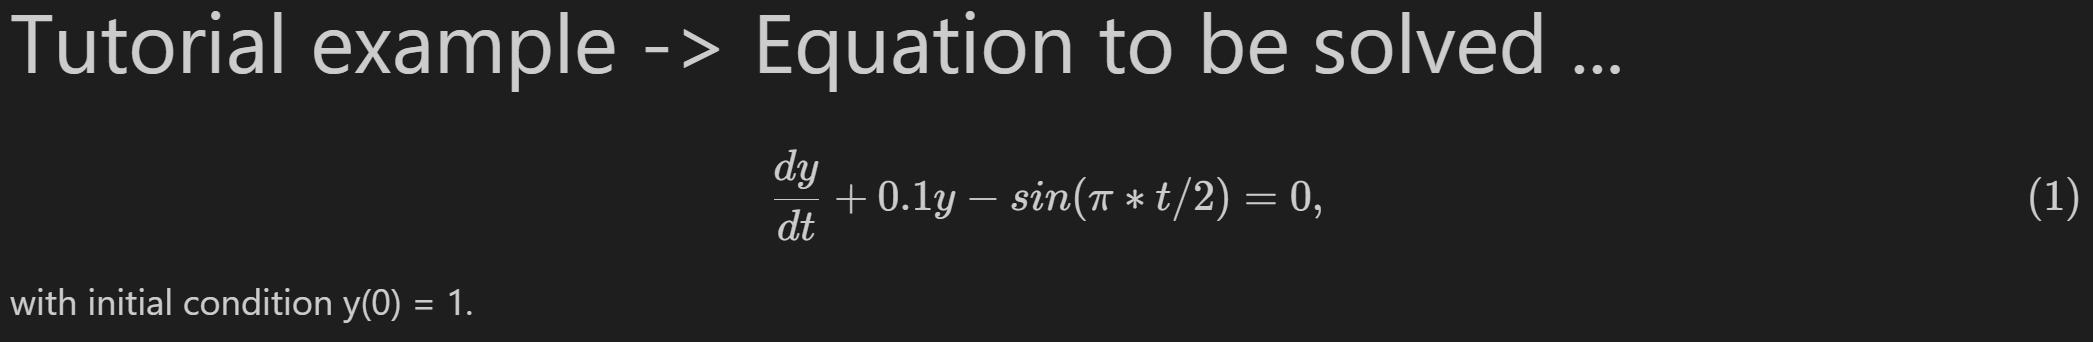

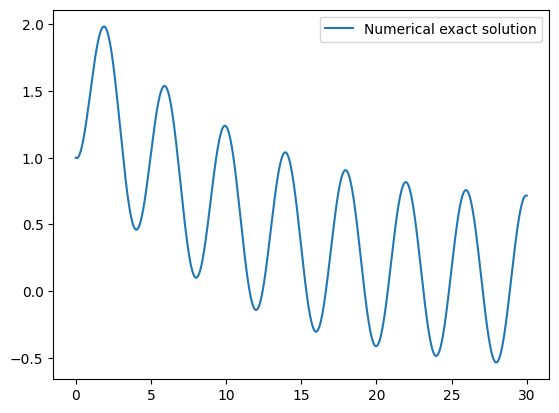

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def oscillator_model(t):
    def func(y, t):
        return - 0.1 * y + np.sin(np.pi * t / 2.0)
    y0 = 1.0
    return odeint(func, y0, t)

t = np.arange(0, 30, 0.01)[:, None]
y = oscillator_model(np.ravel(t))

plt.figure()
plt.plot(t, y, label="Numerical exact solution")
plt.legend()
plt.show()


In [19]:
import deepxde as dde
from deepxde.backend import tf

geom = dde.geometry.TimeDomain(0.0, 30.0)

def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    return dy_dt + 0.1 * y - tf.sin(np.pi * t / 2)

def boundary(t, on_boundary):
    return on_boundary

t_point = np.linspace(0.0, 30.0, 1)[:, None]
y_point = np.interp(t_point.ravel(), t.ravel(), y.ravel())[:, None]
t_y_point = dde.PointSetBC(t_point, y_point)

ic = dde.icbc.IC(geom, lambda x: 1, boundary, component=0)
bc = dde.DirichletBC(geom, lambda x: 1, boundary, component=0)

data = dde.data.PDE(
    geom, ode, [ic, bc, t_y_point], train_distribution = "uniform", num_domain = 50, num_boundary = 1
)

net = dde.maps.FNN([1] + [32] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(epochs=24000)

y_pred = model.predict(t)

# losshistory, train_state = model.train(epochs=48000)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
Building feed-forward neural network...
'build' took 0.049186 s

'compile' took 0.492669 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.39e-01, 1.00e+00, 1.00e+00, 1.00e+00]    [5.39e-01, 1.00e+00, 1.00e+00, 1.00e+00]    []  
1000      [4.23e-01, 3.96e-10, 3.96e-10, 3.96e-10]    [4.23e-01, 3.96e-10, 3.96e-10, 3.96e-10]    []  
2000      [3.19e-01, 9.30e-09, 9.30e-09, 9.30e-09]    [3.19e-01, 9.30e-09, 9.30e-09, 9.30e-09]    []  
3000      [2.23e-01, 4.17e-07, 4.17e-07, 4.17e-07]    [2.23e-01, 4.17e-07, 4.17e-07, 4.17e-07]    []  
4000      [1.56e-01, 3.98e-07, 3.98e-07, 3.98e-07]    [1.56e-01, 3.98e-07, 3.98e-07, 3.98e-07]    []  
5000      [9.65e-02, 9.67e-11, 9.67e-11, 9.67e-11]    [9.65e-02, 9.67e-11, 9.67e-11, 9.67e-11]    []  
6000      [7.56e-02, 7.19e-10, 7.19e-10, 7.19e-10]    [7.56e-02, 7.19e-10, 7.19e-10, 7.19e-10]    []  
7000      [3.84e-02, 1.54e-04, 1.54e-04

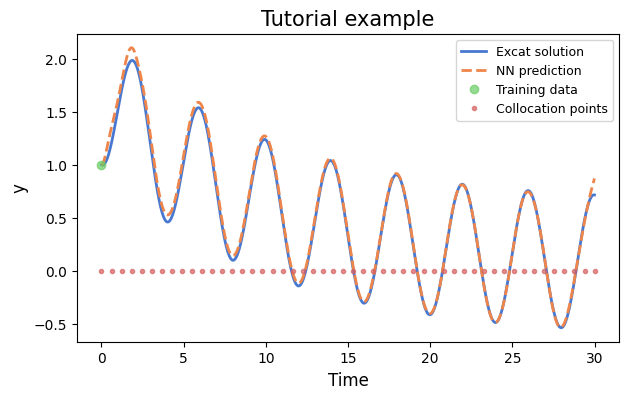

In [20]:
import seaborn as sns

palette = sns.color_palette("muted")

num_domain = np.linspace(0, 30, 50)

plt.figure(figsize=(7, 4))
plt.plot(t, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(t, y_pred, '--', color=palette[1], linewidth=2, label='NN prediction')
plt.plot(t_point, y_point, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.plot(num_domain, np.zeros_like(num_domain), '.', color=palette[3], linewidth=2, alpha=0.7, label='Collocation points')
plt.title('Tutorial example', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.show()